<a href="https://colab.research.google.com/github/as791/Brain-Tumor-Segmentation-BRaTS-18/blob/master/Main_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connecting Google Drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Dataset')

In [ ]:
os.listdir()

['LGG',
 'HGG',
 'survival_data.csv',
 'Model_logs',
 'Training Data',
 'Test Data',
 'Validation Data',
 'Extracted Data',
 'Saved Models ',
 'Miscellaneous ',
 'Model Checkpoints',
 'unet.png',
 'Main_file.ipynb']

#Loading data from mri scans

In [ ]:
path1 = './HGG/'
path2 = './LGG/'

In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 42.5MB 169kB/s 


In [ ]:
import SimpleITK as sitk 
from tqdm import tqdm
import numpy as np

In [ ]:
def load_data(path):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  for p in tqdm(my_dir):
    data_list = sorted(os.listdir(path+p))
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])    
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    data.append([flair,t1,t1ce,t2])
    gt.append(seg)
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  return data,gt

In [ ]:
# for HGG
data1,gt1 = load_data(path1)   #dividing HGG in three parts i.e. 210 into three sets of 70 
# for LGG
# data2,gt2 = load_data(path2)  #LGG having 75 patients 

100%|██████████| 75/75 [03:53<00:00,  2.78s/it]


In [ ]:
# data2.shape,gt2.shape,data2.dtype,gt2.dtype

((75, 4, 155, 240, 240), (75, 155, 240, 240), dtype('int16'), dtype('int16'))

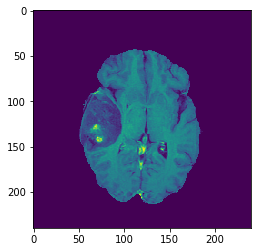

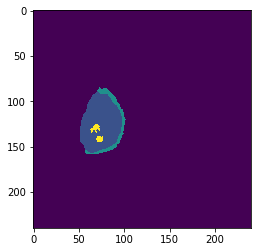

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(data2[45,2,65,:,:])
# plt.show()
# plt.imshow(gt2[45,65,:,:])
# plt.show()

In [ ]:
# np.save('data2.npy',data2)
# np.save('gt2.npy',gt2)

#Loading saved data for usage

In [ ]:
import numpy as np
from tqdm import tqdm

In [ ]:
data = np.load('./Extracted Data/data2.npy')
gt = np.load('./Extracted Data/gt2.npy')

In [ ]:
data = np.transpose(data,(0,2,3,4,1))

In [ ]:
data.shape,gt.shape,data.dtype,gt.dtype

((75, 155, 240, 240, 4), (75, 155, 240, 240), dtype('int16'), dtype('int16'))

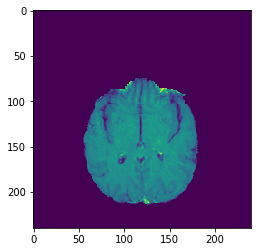

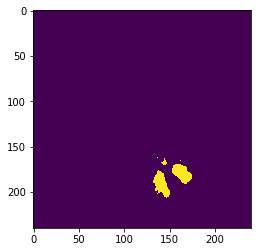

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data[50,70,:,:,2])
plt.show()
plt.imshow(gt[50,70,:,:])
plt.show()

# Pre-Processing of data 

In [ ]:
data.shape,gt.shape

((75, 155, 240, 240, 4), (75, 155, 240, 240))

In [ ]:
'''Taking Only from 30th slice till 120th slice for creating the data and also cropping the images to discard useless background 
So, from 240x240x4 each image now becomes of shape 192x192x4 taking all 4 modalities''' 

In [ ]:
data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])
gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])

In [ ]:
data.shape,gt.shape

((6750, 192, 192, 4), (6750, 192, 192, 1))

In [ ]:
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 to do one hot encoding (Consider value 3 in results in output as class 4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [ ]:
%tensorflow_version 1.x

In [ ]:
from keras.utils import to_categorical,normalize
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

Using TensorFlow backend.


In [ ]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((4050, 192, 192, 4),
 (4050, 192, 192, 4),
 (1350, 192, 192, 4),
 (1350, 192, 192, 4),
 (1350, 192, 192, 4),
 (1350, 192, 192, 1))

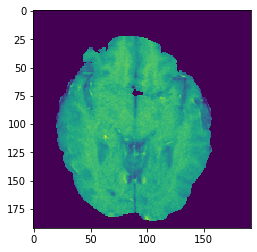

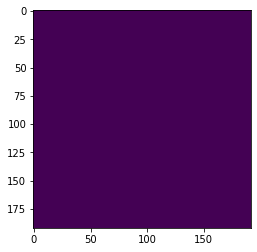

In [ ]:
plt.imshow(X_train[1,:,:,1])
plt.show()
plt.imshow(Y_train[1,:,:,3])
plt.show()

In [ ]:
#Saving the data one by one total set 4
np.save('./Training Data/X_train4.npy',X_train)
np.save('./Training Data/Y_train4.npy',Y_train)
np.save('./Validation Data/X_val4.npy',X_val)
np.save('./Validation Data/Y_val4.npy',Y_val)
np.save('./Test Data/X_test4.npy',X_test)
np.save('./Test Data/Y_test4.npy',Y_test)

# U-net + dice loss 

## Loading Data

In [ ]:
'''Using 4 sets made by pre-processing one by one each having training set of 3780, validaiton of 1260 and test data of 1260 slices of mri scans'''

'Using 4 sets made by pre-processing one by one each having training set of 3780, validaiton of 1260 and test data of 1260 slices of mri scans'

In [ ]:
import numpy as np

In [ ]:
# X_train = np.load('./Training Data/X_train1.npy')
# Y_train = np.load('./Training Data/Y_train1.npy')
# X_train = np.load('./Training Data/X_train2.npy')
# Y_train = np.load('./Training Data/Y_train2.npy')
# X_train = np.load('./Training Data/X_train3.npy')
# Y_train = np.load('./Training Data/Y_train3.npy')
X_train = np.load('./Training Data/X_train4.npy')
Y_train = np.load('./Training Data/Y_train4.npy')

In [ ]:
# X_val = np.load('./Validation Data/X_val1.npy')
# Y_val = np.load('./Validation Data/Y_val1.npy')
# X_val = np.load('./Validation Data/X_val2.npy')
# Y_val = np.load('./Validation Data/Y_val2.npy')
# X_val = np.load('./Validation Data/X_val3.npy')
# Y_val = np.load('./Validation Data/Y_val3.npy')
X_val = np.load('./Validation Data/X_val4.npy')
Y_val = np.load('./Validation Data/Y_val4.npy')

In [ ]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((4050, 192, 192, 4),
 (4050, 192, 192, 4),
 (1350, 192, 192, 4),
 (1350, 192, 192, 4))

In [ ]:
 %tensorflow_version 1.x
from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers

Using TensorFlow backend.


In [ ]:
############################################ U-net #############################################

############ Encoder #############
input_ = Input(shape=(192,192,4),name='input')                                              

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(input_)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_conv1)
block1_norm = BatchNormalization(name='block1_batch_norm')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_conv1)
block2_norm = BatchNormalization(name='block2_batch_norm')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_conv1)
block3_norm = BatchNormalization(name='block3_batch_norm')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_conv1)
block4_norm = BatchNormalization(name='block4_batch_norm')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm)
################### Encoder end ######################

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)
# encoder_dropout_2 = Dropout(0.2,name='encoder_dropout_2')(block5_conv1)

########### Decoder ################

up_pool1 = Conv2DTranspose(1024,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = concatenate([block4_norm,up_pool1],name='merged_block1')
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = concatenate([block3_norm,up_pool2],name='merged_block2')
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = concatenate([block2_norm,up_pool3],name='merged_block3')
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = concatenate([block1_norm,up_pool4],name='merged_block4')
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)
############ Decoder End ######################################

# decoder_dropout_2 = Dropout(0.2,name='decoder_dropout_2')(decod_block4_conv1)

pre_output = Conv2D(64,1,padding = 'same',activation='relu',name='pre_output')(decod_block4_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = input_, outputs = output)
model.summary()

In [ ]:
from keras.utils import  plot_model


## Loss Function

In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef])
model.load_weights('./Model Checkpoints/weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = './Model Checkpoints/weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=32,epochs=16,callbacks=[training_log,checkpointer],shuffle=True)

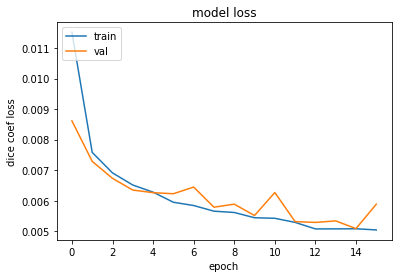

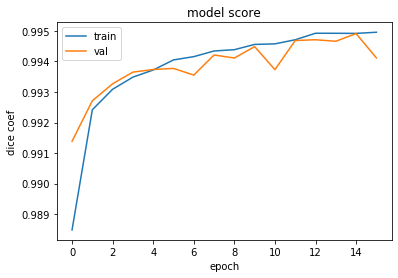

In [ ]:
# summarize history for loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('dice coef loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model score')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# X_test = np.load('./Test Data/X_test1.npy')
# Y_test = np.load('./Test Data/Y_test1.npy')
# X_test = np.load('./Test Data/X_test2.npy')
# Y_test = np.load('./Test Data/Y_test2.npy')
# X_test = np.load('./Test Data/X_test3.npy')
# Y_test = np.load('./Test Data/Y_test3.npy')
X_test = np.load('./Test Data/X_test4.npy')
Y_test = np.load('./Test Data/Y_test4.npy')

In [ ]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

In [ ]:
np.unique(Y_pre)

array([0, 1, 2, 3])

In [ ]:
Y_pre.shape

(1350, 192, 192)

In [ ]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [ ]:
Y_test.shape,X_test.shape

((1350, 192, 192, 1), (1350, 192, 192, 4))

In [ ]:
for i in range(498,500):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [ ]:
from keras.utils import to_categorical
Y_test_encod = to_categorical(Y_test)

In [ ]:
model.evaluate(X_test,Y_test_encod,verbose=0)

[0.005474171455673598, 0.9945260692525792]

In [ ]:
model.save('./Saved Models /model.h5',overwrite=True)

#Evaluation of the Model

In [ ]:
import numpy as np
X_test1 = np.load('./Test Data/X_test1.npy')
X_test2 = np.load('./Test Data/X_test2.npy')
X_test3 = np.load('./Test Data/X_test3.npy')
X_test4 = np.load('./Test Data/X_test4.npy')

Y_test1 = np.load('./Test Data/Y_test1.npy')
Y_test2 = np.load('./Test Data/Y_test2.npy')
Y_test3 = np.load('./Test Data/Y_test3.npy')
Y_test4 = np.load('./Test Data/Y_test4.npy')

In [ ]:
from keras.utils import to_categorical
Y_test_encod1 = to_categorical(Y_test1)
Y_test_encod2 = to_categorical(Y_test2)
Y_test_encod3 = to_categorical(Y_test3)
Y_test_encod4 = to_categorical(Y_test4)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5),loss=[dice_coef_loss],metrics=[dice_coef])

In [ ]:
model.load_weights('./Model Checkpoints/weights.hdf5')

In [ ]:
print('HGG Test set no: 1 with Dice Coefficient:- %.4f'%float(list(model.evaluate(X_test1,Y_test_encod1,batch_size=32,verbose=2))[1]))
print('HGG Test set no: 2 with Dice Coefficient:- %.4f'%float(list(model.evaluate(X_test2,Y_test_encod2,batch_size=32,verbose=2))[1]))
print('HGG Test set no: 3 with Dice Coefficient:- %.4f'%float(list(model.evaluate(X_test3,Y_test_encod3,batch_size=32,verbose=2))[1]))
print('LGG Test set no: 4 with Dice Coefficient:- %.4f'%float(list(model.evaluate(X_test4,Y_test_encod4,batch_size=32,verbose=2))[1]))

HGG Test set no: 1 with Dice Coefficient:- 0.9795
HGG Test set no: 2 with Dice Coefficient:- 0.9855
HGG Test set no: 3 with Dice Coefficient:- 0.9793
LGG Test set no: 4 with Dice Coefficient:- 0.9950


In [ ]:
Y_pred1 = np.argmax(model.predict(X_test1),axis=-1).reshape(-1,192,192,1)
Y_pred2 = np.argmax(model.predict(X_test2),axis=-1).reshape(-1,192,192,1)
Y_pred3 = np.argmax(model.predict(X_test3),axis=-1).reshape(-1,192,192,1)
Y_pred4 = np.argmax(model.predict(X_test4),axis=-1).reshape(-1,192,192,1)

In [ ]:
import matplotlib.pyplot as plt
for i in range(450,500):
  print('HGG test set no: 1 '+ 'slice no: ' + str(i))
  plt.imshow(X_test1[i,:,:,2])
  plt.show()
  print('Predicted:- ')
  plt.imshow(Y_pred1[i,:,:,0])
  plt.show()
  print('Actual:- ')
  plt.imshow(Y_test1[i,:,:,0])
  plt.show()
for i in range(450,500):
  print('HGG test set no: 2 '+ 'slice no: ' + str(i))
  plt.imshow(X_test2[i,:,:,2])
  plt.show()
  print('Predicted:- ')
  plt.imshow(Y_pred2[i,:,:,0])
  plt.show()
  print('Actual:- ')
  plt.imshow(Y_test2[i,:,:,0])
  plt.show()
for i in range(450,500):
  print('HGG test set no: 3 '+ 'slice no: ' + str(i))
  plt.imshow(X_test3[i,:,:,2])
  plt.show()
  print('Predicted:- ')
  plt.imshow(Y_pred3[i,:,:,0])
  plt.show()
  print('Actual:- ')
  plt.imshow(Y_test3[i,:,:,0])
  plt.show()
for i in range(450,500):
  print('LGG test slice no: ' + str(i))
  plt.imshow(X_test4[i,:,:,1])
  plt.show()
  print('Predicted:- ')
  plt.imshow(Y_pred4[i,:,:,0])
  plt.show()
  print('Actual:- ')
  plt.imshow(Y_test4[i,:,:,0])
  plt.show()